In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [100]:
n_neurons = 1024
n_steps = 20000
n_driving_current = 32
n_recorded_neuron = 64
time_spacing = 0.02

In [30]:
"""generate weights"""
np.random.seed(123)
weight_sigma = 30.
weights = np.random.normal(0, weight_sigma, (n_neurons, n_neurons))/np.sqrt(n_neurons)
np.fill_diagonal(weights, 0.)
weights.tofile('weights_1024.bin')

In [31]:
"""generate inital neuron state"""
vs = np.ones((n_neurons, 1))*(-50.0)
vs = np.arange(n_neurons).reshape((n_neurons, 1))
gates = np.random.uniform(0, 1, (n_neurons, 3))
states = np.concatenate((vs, gates), axis=-1)
states.tofile("initial_states_1024.bin")

In [32]:
"""generate driving currents"""
def random_harmonics(seed, n_harmonics, period_range, coeff_range, amplitude):
    np.random.seed(seed)
    periods = np.random.uniform(period_range[0], period_range[1], n_harmonics)
    coeffs = np.random.uniform(coeff_range[0], coeff_range[1], n_harmonics)
    coeffs = amplitude/np.sum(np.abs(coeffs))*coeffs
    phases = np.random.uniform(0, 2*np.pi, n_harmonics)
    def fun(t):
        tmps = coeffs*np.sin(2*np.pi*t/periods + phases)
        return np.sum(tmps)
        # return 0.
    return np.vectorize(fun)

driving_currents = np.zeros((n_driving_current, n_steps))
for i in range(n_driving_current):
    driving_currents[i] = random_harmonics(seed=i+n_neurons, n_harmonics=10, period_range=(5, 50), coeff_range=(0, 1), amplitude=30)(np.arange(0, n_steps)*time_spacing)
# driving_currents = np.ones((2, n_steps))*100 # for simplicity, just use a constant current. 
driving_currents.tofile("driving_currents_1024_32.bin")

Text(0, 0.5, 'current (nA)')

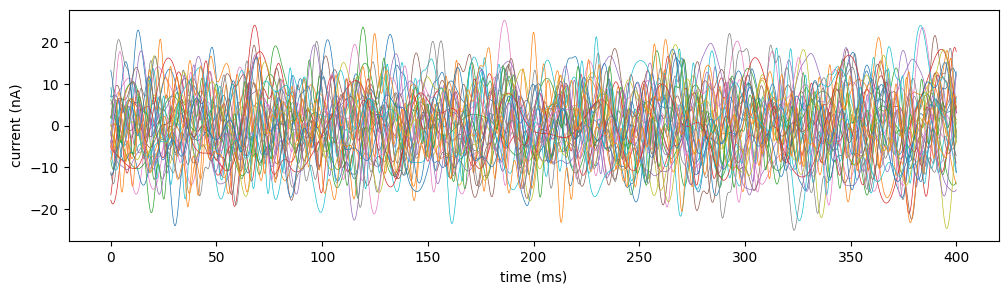

In [114]:
driving_currents = np.fromfile("driving_currents_1024_32.bin", dtype=np.float64).reshape((n_driving_current, n_steps))
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
# for i in range(n_recorded_neuron):
for i in range(n_driving_current):
    axes.plot(np.arange(n_steps)*time_spacing, driving_currents[i, :], linewidth=0.5)
axes.set_xlabel("time (ms)")
axes.set_ylabel("current (nA)")

Text(0, 0.5, 'current (nA)')

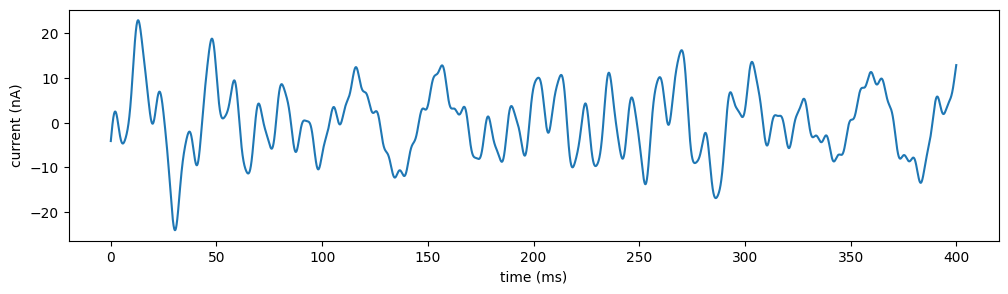

In [112]:
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
# for i in range(n_recorded_neuron):
for i in range(1):
    axes.plot(np.arange(n_steps)*time_spacing, driving_currents[0, :])
axes.set_xlabel("time (ms)")
axes.set_ylabel("current (nA)")

In [81]:
"""get recorded data"""
voltage_record_openmp = np.fromfile("voltage_record_openmp.bin", dtype=np.float64).reshape((n_recorded_neuron, n_steps))
voltage_record_mpi = np.fromfile("voltage_record_mpi.bin", dtype=np.float64).reshape((n_recorded_neuron, n_steps))
voltage_record_mpi_openmp = np.fromfile("voltage_record_mpi_openmp.bin", dtype=np.float64).reshape((n_recorded_neuron, n_steps))

Text(0, 0.5, 'voltage (mV)')

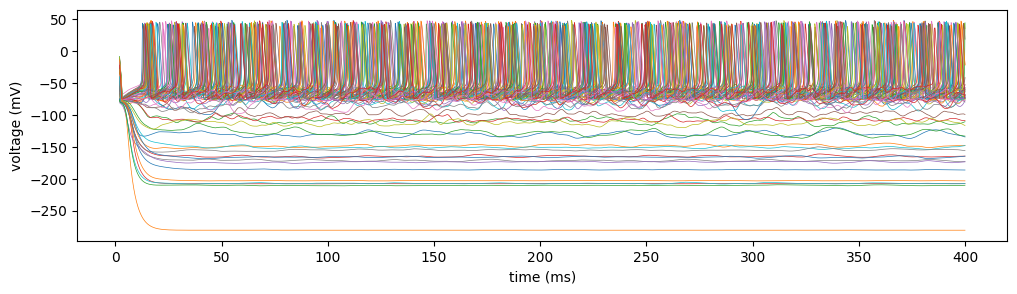

In [115]:
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
# for i in range(n_recorded_neuron):
for i in range(n_recorded_neuron):
    axes.plot(np.arange(n_steps)[100:]*time_spacing, voltage_record_openmp[i, 100:], linewidth=0.5)
axes.set_xlabel("time (ms)")
axes.set_ylabel("voltage (mV)")

Text(0, 0.5, 'voltage (mV)')

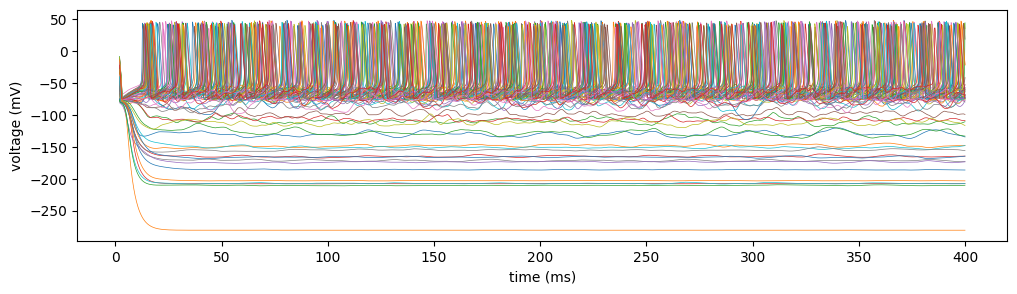

In [116]:
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
# for i in range(n_recorded_neuron):
for i in range(n_recorded_neuron):
    axes.plot(np.arange(n_steps)[100:]*time_spacing, voltage_record_mpi[i, 100:], linewidth=0.5)
axes.set_xlabel("time (ms)")
axes.set_ylabel("voltage (mV)")

Text(0, 0.5, 'voltage (mV)')

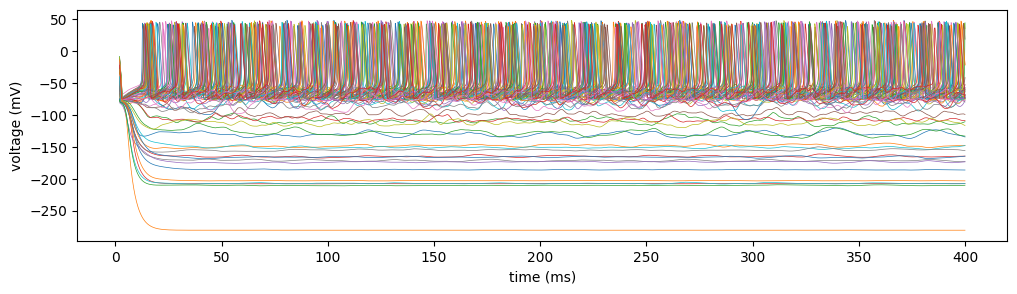

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
# for i in range(n_recorded_neuron):
for i in range(n_recorded_neuron):
    axes.plot(np.arange(n_steps)[100:]*time_spacing, voltage_record_mpi_openmp[i, 100:], linewidth=0.5)
axes.set_xlabel("time (ms)")
axes.set_ylabel("voltage (mV)")

In [33]:
tmp = np.sort(np.random.choice(n_neurons, n_driving_current, replace=False))
np.savetxt("driven_neuron_indices.txt", tmp, fmt="%d", delimiter=' ', newline=", ")

In [34]:
tmp = np.sort(np.random.choice(n_neurons, n_recorded_neuron, replace=False))
np.savetxt("recorded_neuron_indices.txt", tmp, fmt="%d", delimiter=' ', newline=", ")

In [78]:
scaling_mpi = np.array([[1, 2, 4, 8, 16, 32, 64, 128],[420.751, 211.159, 107.127, 54.7848, 28.8484, 17.5166, 15.0629, 19.2839]])
scaling_openmp = np.array([[1, 2, 4, 8, 16, 32, 64, 128],[415.9, 208.275, 107.6, 52.7744, 27.1894, 15.0559, 8.76014, 7.73278]])
scaling_mpi_openmp_2 = np.array([[2, 4, 8, 16, 32, 64, 128],[214.641, 108.771, 54.5004, 28.6762, 15.4349, 8.90612, 7.10564]])
scaling_mpi_openmp_4 = np.array([[4, 8, 16, 32, 64, 128],[108.222, 54.9228, 28.182, 14.8324, 8.5483, 7.96304]])

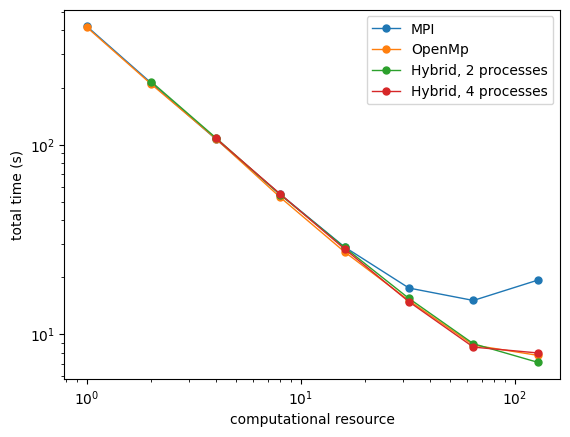

In [128]:
plt.plot(scaling_mpi[0, :], scaling_mpi[1, :], marker=".", markersize=10, linewidth=1, label="MPI")
plt.plot(scaling_openmp[0, :], scaling_openmp[1, :], marker=".", markersize=10, linewidth=1, label="OpenMp")
plt.plot(scaling_mpi_openmp_2[0, :], scaling_mpi_openmp_2[1, :], marker=".", markersize=10, linewidth=1, label="Hybrid, 2 processes")
plt.plot(scaling_mpi_openmp_4[0, :], scaling_mpi_openmp_4[1, :], marker=".", markersize=10, linewidth=1, label="Hybrid, 4 processes")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("total time (s)")
plt.xlabel("computational resource")
plt.legend()